# SageMaker DeepAR

<a href='https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html'>Amazon SageMaker DeepAR</a> is a supervised learning algorithm for forecasting scalar time series using recurrent neural networks (RNN). Classical forecasting methods, such as Autoregressive Integrated Moving Average (ARIMA) or Exponential Smoothing (ETS), fit one model to each individual time series, and then use that model to extrapolate the time series into the future. In many applications, however, you might have many similar time series across a set of cross-sectional units (for example, demand for different products, load of servers, requests for web pages, and so on). In this case, it can be beneficial to train a single model jointly over all of these time series. DeepAR takes this approach, training a model for predicting a time series over a large set of (related) time series.

Technical details can be found in this <a href='https://arxiv.org/pdf/1704.04110.pdf'>arXiv paper</a>.

In [1]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

# Configure S3 Storage and Container

In [3]:
bucket = '<s3_bucket_name_here>'
prefix = 'sagemaker/deepar/HEC'

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

Next, we configure the container image to be used for the region that we are running in.

In [4]:
containers = {
    'us-east-1': '522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:latest',
    'us-east-2': '566113047672.dkr.ecr.us-east-2.amazonaws.com/forecasting-deepar:latest',
    'us-west-2': '156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:latest',
    'eu-west-1': '224300973850.dkr.ecr.eu-west-1.amazonaws.com/forecasting-deepar:latest',
    'ap-northeast-1': '633353088612.dkr.ecr.ap-northeast-1.amazonaws.com/forecasting-deepar:latest',
    'ap-northeast-2': '204372634319.dkr.ecr.ap-northeast-2.amazonaws.com/forecasting-deepar:latest'
}
image_name = containers[boto3.Session().region_name]

# Prepare Data

Specify the frequency of the data (hourly) and set the number of datapoints to predict and to use for prediction.

In [5]:
freq = 'H'
prediction_length = 500
context_length = 500

## Load Dataset

In [9]:
raw = pd.read_csv('../datasets/household-electricity.csv', parse_dates=[0])
df = raw.copy()
df.set_index('DateTime', inplace=True)
df = df.resample(freq).mean()
print(df.shape)
df.head()

(26305, 321)


,household_0,household_1,household_2,household_3,household_4,household_5,household_6,household_7,household_8,household_9,...,household_311,household_312,household_313,household_314,household_315,household_316,household_317,household_318,household_319,household_320
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,12.690355,68.278805,231.972198,412.601626,213.414634,1053.571429,27.133974,838.383838,223.776224,263.440860,...,675.438596,370.449679,80100.0,4717.299578,5000.000000,46.936115,36.863663,1556.628622,180.300501,2160.557185
2012-01-01 01:00:00,16.497462,90.327169,309.296264,552.845528,289.024390,1360.119048,27.133974,1101.010101,269.230769,337.634409,...,803.728070,450.392577,95200.0,4641.350211,6613.636364,63.885267,45.055588,2175.592625,250.417362,2832.844575
2012-01-01 02:00:00,19.035533,93.883357,309.296264,556.910569,269.512195,1238.095238,27.699265,1023.569024,267.482517,297.849462,...,815.789474,428.265525,96600.0,4282.700422,6568.181818,62.581486,40.959626,2191.395961,215.358932,2760.997067
2012-01-01 03:00:00,17.766497,88.904694,309.296264,441.056911,210.975610,842.261905,22.611645,831.649832,176.573427,208.602151,...,799.342105,290.506781,94500.0,4219.409283,6363.636364,63.885267,36.863663,1313.432836,191.986644,2733.137830
2012-01-01 04:00:00,19.035533,87.482219,309.296264,343.495935,189.024390,645.833333,14.132278,730.639731,185.314685,176.344086,...,805.921053,276.945039,91300.0,4113.924051,6295.454545,73.011734,38.033938,1375.768218,188.647746,2719.941349


## Prepare data for SageMaker

Extract time series and set aside data for testing.

In [10]:
time_series = []
for k in df.columns:
    time_series.append(df[k])
    
time_series_training = []
for ts in df.columns:
    time_series_training.append(df.iloc[:-prediction_length][ts])

Visualise time series example.

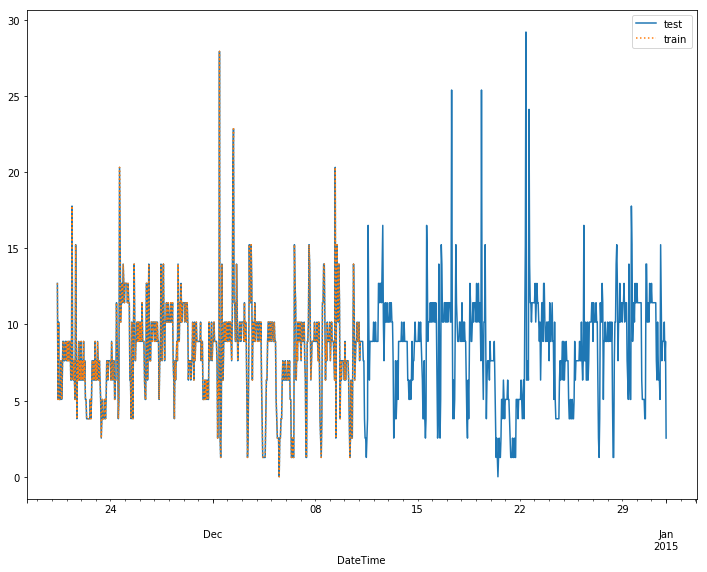

In [11]:
time_series[0][-1000:].plot(label='test', figsize=(12, 9))
time_series_training[0][-500:].plot(label='train', ls=':')
plt.legend()
plt.show()

Convert time series into JSON strings for DeepAR.

In [12]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [13]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

# Train Model

Define the estimator for training and set hyperparameters.

In [14]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p3.8xlarge',
    base_job_name='HEC-deepar',
    output_path="s3://" + s3_output_path
)

In [15]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [16]:
estimator.set_hyperparameters(**hyperparameters)

Launch training job.

In [17]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: HEC-deepar-2018-07-06-21-24-58-577


.....................
Arguments: train
[07/06/2018 21:28:25 INFO 140601002444608] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'dropout_rate': u'0.10', u'cardinality': u'', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'mini_batch_size': u'32', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[07/06/2018 21:28:25 INFO 140601002444608] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'dropout_rate': u'0.05', u'learning_rate': u'0.001', u'num_cells': u'40', u'prediction_length': u'500', u'epochs': u'20', u'time_freq': u'H', u'context_length': u'500', u'num_layers': u'3', u'mini_batch_size': u'32', u'likelihood': u'gaussian', u'early_stopping_patience': u'1

# Create Endpoint and Predictor

In [18]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: HEC-deepar-2018-07-06-21-24-58-577
INFO:sagemaker:Creating endpoint-config with name HEC-deepar-2018-07-06-21-24-58-577
INFO:sagemaker:Creating endpoint with name HEC-deepar-2018-07-06-21-24-58-577


-------------------------------------------------------------------------!

Create utility class to make predictions from Pandas Series.

In [19]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [20]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

# Make Predictions

In [21]:
list_of_df = predictor.predict(time_series_training[:5])
actual_data = time_series

In [25]:
tic = time.time()
for i in range(5, len(time_series), 5):
    toc = time.time()
    print("Running predictions for time series {} to {}... (cumulative time: {:.1f}s.)".format(i, i+5, toc-tic))
    pred = predictor.predict(time_series_training[i:(i+5)])
    list_of_df = list_of_df + pred

Running predictions for time series 5 to 10... (cumulative time: 0.0s.)
Running predictions for time series 10 to 15... (cumulative time: 23.3s.)
Running predictions for time series 15 to 20... (cumulative time: 46.4s.)
Running predictions for time series 20 to 25... (cumulative time: 67.3s.)
Running predictions for time series 25 to 30... (cumulative time: 88.1s.)
Running predictions for time series 30 to 35... (cumulative time: 109.1s.)
Running predictions for time series 35 to 40... (cumulative time: 130.0s.)
Running predictions for time series 40 to 45... (cumulative time: 151.0s.)
Running predictions for time series 45 to 50... (cumulative time: 171.8s.)
Running predictions for time series 50 to 55... (cumulative time: 192.9s.)
Running predictions for time series 55 to 60... (cumulative time: 214.0s.)
Running predictions for time series 60 to 65... (cumulative time: 235.2s.)
Running predictions for time series 65 to 70... (cumulative time: 256.0s.)
Running predictions for time ser

Visualise some example time series forecasts.

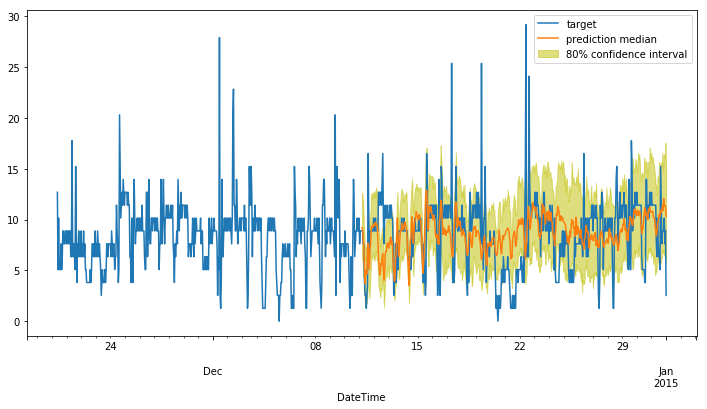

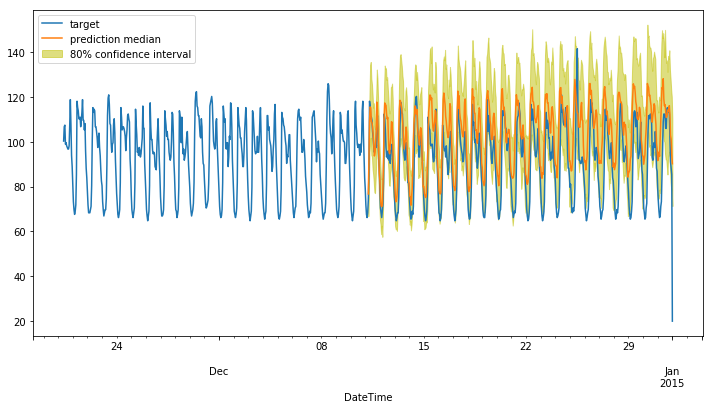

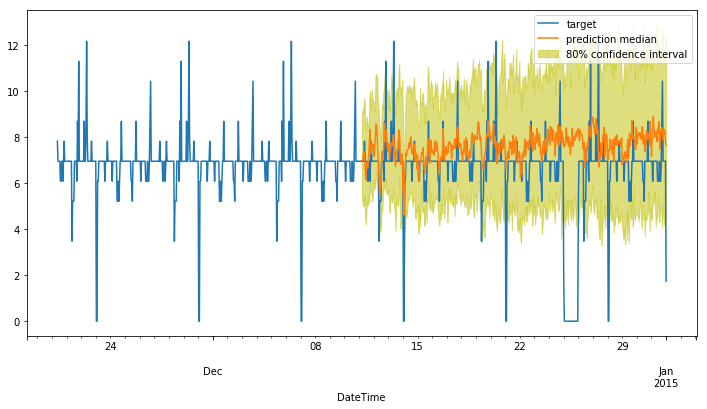

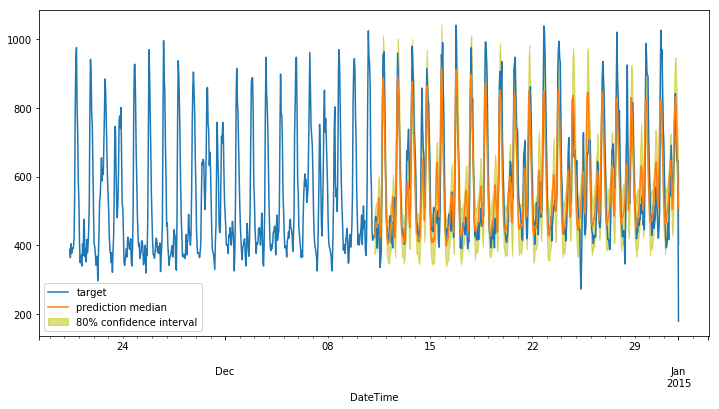

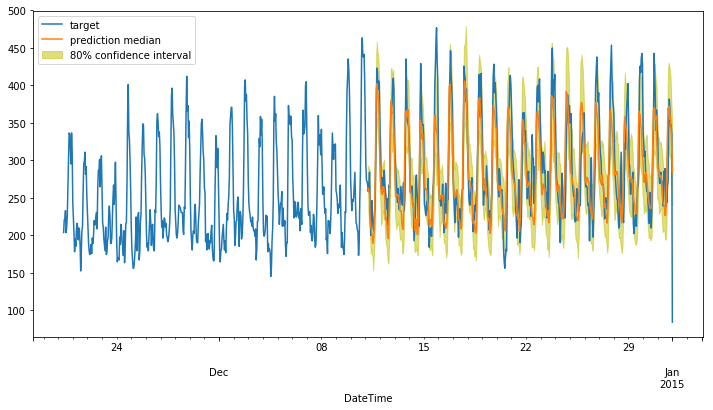

In [26]:
for k in range(5):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

# Evaluate DeepAR

In [28]:
results = df.iloc[-500:, :].copy()
for i in range(len(results.columns)):
    results['household_%s_pred' % (i)] = list_of_df[i]['0.5'].values

In [29]:
results.head()

,household_0,household_1,household_2,household_3,household_4,household_5,household_6,household_7,household_8,household_9,...,household_311_pred,household_312_pred,household_313_pred,household_314_pred,household_315_pred,household_316_pred,household_317_pred,household_318_pred,household_319_pred,household_320_pred
DateTime,,,,,,,,,,,,,,,,,,,,,
2014-12-11 05:00:00,8.883249,73.968706,6.950478,422.764228,258.536585,577.380952,16.393443,797.979798,188.811189,192.473118,...,857.770874,395.788177,57390.460938,3817.610596,4282.692871,129.235687,24.126133,2183.441895,276.351257,2666.377930
2014-12-11 06:00:00,8.883249,85.348506,6.950478,461.382114,265.853659,750.000000,17.524025,744.107744,178.321678,200.000000,...,879.644226,444.973114,55021.933594,3998.477051,4603.552246,119.931183,21.491577,1996.345825,344.119293,2721.620361
2014-12-11 07:00:00,7.614213,118.065434,6.950478,483.739837,284.146341,779.761905,16.958734,969.696970,201.048951,203.225806,...,839.501587,485.460327,57798.527344,4021.759766,5338.134277,125.267723,17.486246,1737.481079,462.993042,2840.482910
2014-12-11 08:00:00,7.614213,115.931721,6.950478,475.609756,230.487805,931.547619,11.871114,919.191919,222.027972,189.247312,...,1037.279785,625.140930,71376.523438,4453.231445,6889.574219,167.416809,6.626417,1738.099609,559.499268,3022.174072
2014-12-11 09:00:00,3.807107,110.241821,7.819288,392.276423,200.000000,880.952381,15.262860,1063.973064,407.342657,215.053763,...,1392.443359,1096.906250,107249.781250,5354.665527,9451.377930,311.174683,4.808853,1792.783691,560.889832,3214.109619


Power must be positive, so we set any negative values equal to zero as this can only improve the accuracy of the model.

In [30]:
results0 = results.copy()
results0[results0 < 0] = 0

In [32]:
sRMSEs = []
for i in range(len(df.columns)):
    RMSE = np.sqrt(np.mean(np.square(results0['household_%s' % i] - results0['household_%s_pred' % i])))
    scale = np.mean(results0['household_%s' % i])
    sRMSE = RMSE/scale
    sRMSEs.append(sRMSE)

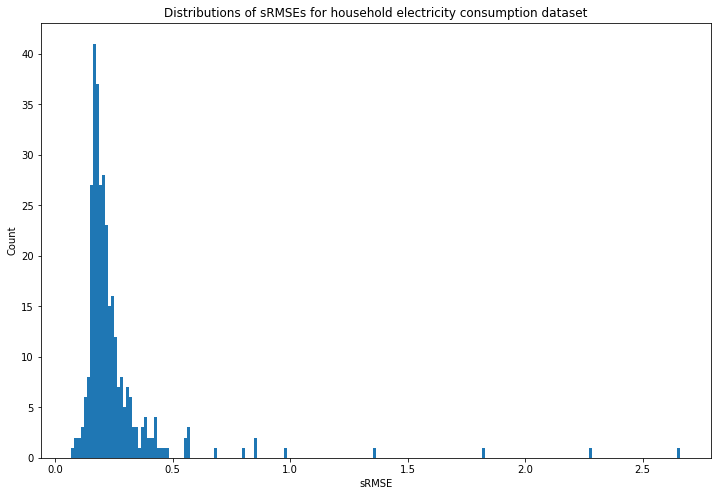

In [33]:
fig = plt.figure(figsize=(12, 8))
plt.hist(sRMSEs, bins=200)
plt.title('Distributions of sRMSEs for household electricity consumption dataset')
plt.xlabel('sRMSE')
plt.ylabel('Count');

In [34]:
sRMSE = np.mean(sRMSEs)
sRMSE

0.2546366118494907

Store the raw results and the computed sRMSE accuracy score for the DeepAR model.

In [35]:
import pickle

with open('hec-results.pkl', 'wb') as f:
    pickle.dump(results, f)
    
with open('hec-sRMSE.pkl', 'wb') as f:
    pickle.dump(sRMSE, f)

# Delete endpoint

In [36]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: HEC-deepar-2018-07-06-21-24-58-577
